In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from net import *
from utils import *
from loss import *

In [2]:
## parameters
img_root = "D:/nyc_taxi/data_min_max"
mask_root = "D:/nyc_taxi/data_min_max"
image_size = 64
batch_size = 24
chunk_size = 5
test_imgs = np.load(img_root+'/test.npy')
test_masks_random = np.load(mask_root+'/test_random_mask.npy')
dataset_test = taxi_data(test_imgs, test_masks_random, image_size, chunk_size)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## load models
model_l1 = PConvUNet(chunk_size=chunk_size)
model_l1.load_state_dict(torch.load(f'../model_states/biased_l1_{chunk_size}'))

<All keys matched successfully>

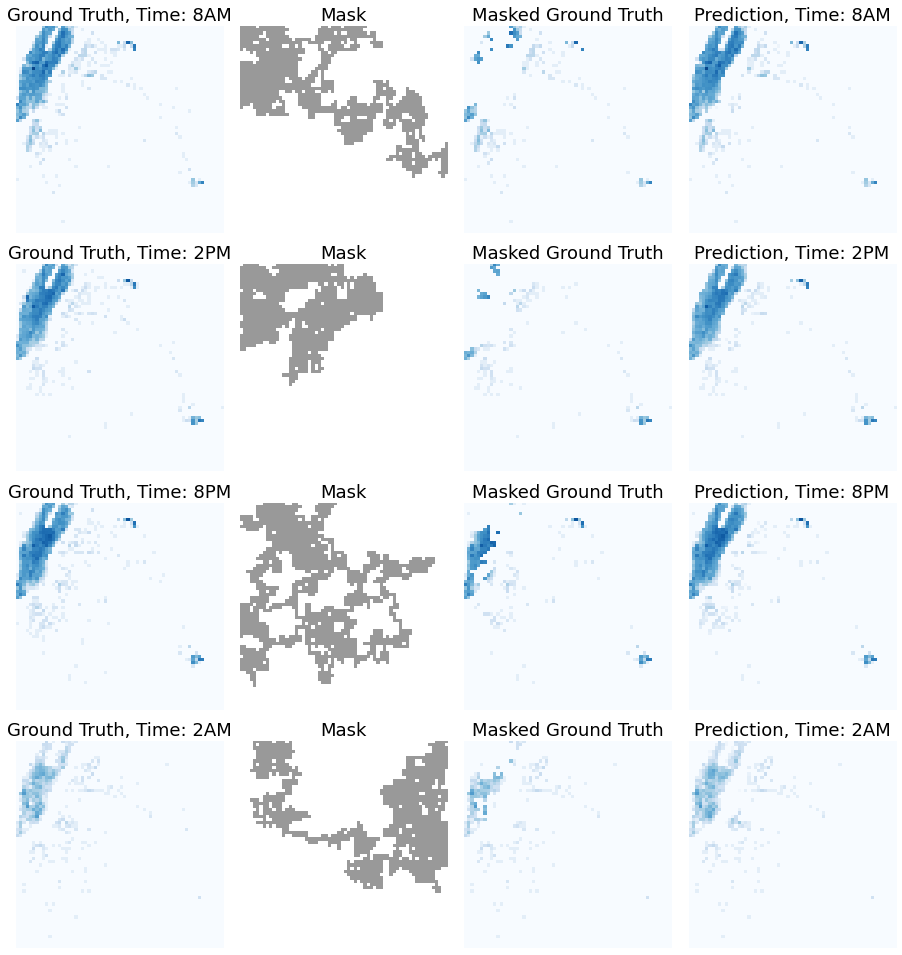

In [5]:
## param
color = 'Blues'
all_time_max = 1428
num = 4

## get test images
times = ['8AM', '2PM', '8PM', '2AM']
indices = [8,14,20,26]
_, gt = zip(*[dataset_test[i] for i in indices])
indices = [1190, 109, 762, 10]
mask, _ = zip(*[dataset_test[i] for i in indices])
mask = torch.stack(mask)
gt = torch.stack(gt)
image = mask*gt

with torch.no_grad():
    output_l1, _ = model_l1(gt, mask)
output_comp_l1 = mask * gt + (1 - mask) * output_l1

## scale back + log transformation
gt = torch.log(gt*all_time_max+1) 
image = torch.log(image*all_time_max+1)
output_comp_l1 = torch.log(output_comp_l1*all_time_max+1)

## the last layer
gt = gt[:,:,-1,:,:]
mask = mask[:,:,-1,:,:]
image = image[:,:,-1,:,:]
output_comp_l1 = output_comp_l1[:,:,-1,:,:]

## visualizations
VMAX=7
fig_size = 16
fig, axs = plt.subplots(num, 4, figsize=(fig_size,fig_size))
fontsize = 18
for i in range(num):
    axs[i,0].imshow(gt[i][0],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,0].set_title(f'Ground Truth, Time: {times[i]}', size=fontsize)
    axs[i,0].axis('off')
    axs[i,1].imshow(mask[i][0],cmap='gray', vmin=-1.5)
    axs[i,1].set_title('Mask', size=fontsize)
    axs[i,1].axis('off')
    axs[i,2].imshow(image[i][0],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,2].set_title('Masked Ground Truth', size=fontsize)
    axs[i,2].axis('off')
    axs[i,3].imshow(output_comp_l1[i][0],vmin=0, vmax=VMAX,cmap='Blues')
    axs[i,3].set_title(f'Prediction, Time: {times[i]}', size=fontsize)
    axs[i,3].axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=-0.1, 
                    hspace=0.15)